# Red Inicial


## Imports


In [6]:
from __future__ import annotations

1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Action
from custom_env.router_env import RouterEnv
from custom_env.states import AttackState, NormalState
from custom_env.utils import Color, Location
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.ppo.ppo import PPO

In [11]:
name = "./models/Example"
logs_path = "./logs/train/"
env_id = "RouterEnv-v0"
save_imgs = True

In [8]:
def train(seed: int, timesteps: int, logs_path: str, progress_bar: bool = True) -> None:
    env: RouterEnv = RouterEnv(seed=seed)
    print("Seed: ", env.get_seed())
    new_logger: Logger = configure(logs_path, ["stdout", "csv"])
    env = Monitor(env, logs_path)

    model: PPO = PPO("MultiInputPolicy", env,
                     verbose=True, seed=seed)

    model.set_logger(new_logger)
    try:
        model.learn(total_timesteps=int(timesteps),
                    progress_bar=progress_bar)
    except KeyboardInterrupt:
        print("Interrupted")
    return model


def get_train_graph(logs_path: str, metric: str = 'train/explained_variance', save: bool = False) -> None:
    train_data_log: DataFrame = pd.read_csv(logs_path+"progress.csv")
    train_data_monitor: DataFrame = pd.read_csv(
        logs_path+"monitor.csv", header=1)

    print("Avaliable metrics: ", train_data_log.columns.to_list())
    if metric not in train_data_log.columns.to_list():
        print(
            f"Metric '{metric}' not found in logs. Probably need more training steps.")
        print("Exiting...")
        return

    fig, ax1 = plt.subplots()

    iterations: Series[int] = train_data_log['time/iterations'].astype(int)

    ax1.set_xlabel('Iterations')
    color = Color.BLUE.value
    ax1.set_ylabel('Reward Mean', color=color)
    ax1.plot(iterations,
             train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
    ax1.tick_params(axis='y', labelcolor=color)

    col = metric

    ax2 = ax1.twinx()
    color = Color.RED.value
    ax2.set_ylabel(col, color=color)
    ax2.plot(iterations, train_data_log[col], color=color, label=col)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_title('Reward vs ' + col)

    fig.tight_layout()
    fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

    if save is True:
        fig.savefig(logs_path + "train_graph.png")
    else:
        plt.show()

    fig, ax1 = plt.subplots()

    episodes = range(len(train_data_monitor['l']))

    ax1.set_xlabel('Episodes')
    color = Color.BLUE.value
    ax1.set_ylabel('Reward', color=color)
    ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Reward vs Time')

    ax2 = ax1.twinx()
    color = Color.RED.value
    ax2.set_ylabel('time', color=color)
    ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

    if save is True:
        fig.savefig(logs_path + "train_graph_reward_time.png")
    else:
        plt.show()


def get_graphs(name: str, logs_path: str, seed: int = 289980628190634006122751570777790489191, save: bool = False) -> None:
    env: RouterEnv = RouterEnv(seed=seed)
    seed: int = env.get_seed()
    model: PPO = PPO.load(name, print_system_info=True)

    num_steps = 1
    obs, _ = env.reset()

    stats = []
    rewards = []

    _states = None
    ant = env._get_info()
    for episode in range(num_steps):

        done = False
        step_counter = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, terminated, info = env.step(action)

            stats.append(info["Stats"])
            rewards.append(reward)

            done: bool = done or terminated

        env.reset()
        step_counter += 1

    acciones = [x["Action"] for x in stats]

    def calcular_stats_acciones(acciones) -> None:
        if isinstance(acciones[-1], int):
            acciones = [Action.int_to_action(a) for a in acciones]
        print(f"{Action.DENY.name}: {acciones.count(Action.DENY)/len(acciones):.2%}")
        print(f"{Action.ALLOW.name}: {acciones.count(Action.ALLOW)/len(acciones):.2%}")
    calcular_stats_acciones(acciones)

    print(f"Seed: {env.get_seed()}")

    fig, ax1 = plt.subplots()
    ocu = [x["OcupacionActual"] for x in stats]
    att = 1
    norm = 0

    estados: list[int] = [norm if x["EstadoMaquina"] ==
                          NormalState.__name__ else att for x in stats]

    acciones: list[int] = [Action.action_to_int(x["Action"]) for x in stats]

    ax1.plot(
        acciones, label=f"Action: Allow {Action.action_to_int(Action.ALLOW)}, Deny {Action.action_to_int(Action.DENY)}", color='#0000FF')
    ax1.plot(ocu, label="Queue Occupancy", color='green')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Queue Occupancy (in %)")
    ax1.set_title("Queue Occupancy vs Actions")

    ax2 = ax1.twinx()
    ax2.bar(range(len(estados)), estados, color='red',
            label="State", alpha=0.20, width=1)
    ax2.set_ylabel("Flow Type")
    ax2.set_yticks([0, 1], [NormalState.__name__, AttackState.__name__])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2)

    if save is True:
        fig.savefig(logs_path + "queue_actions.png")
    else:
        plt.show()

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Acciones y Ocupación')

    ax1.step(range(len(acciones)), acciones,
             label="Acciones", where='post', color='green')
    ax1.step(range(len(ocu)), ocu, label="Ocupación",
             where='mid', color='blue')

    ticks = list(ax1.get_yticks())

    ax1.set_yticks(sorted(ticks))

    ax1.axhline(y=Action.action_to_int(Action.DENY), color='red',
                linestyle='dotted', linewidth=0.8, label='Denegar')
    ax1.axhline(y=Action.action_to_int(Action.ALLOW),
                color='green', linestyle='dotted', linewidth=0.8, label='Permitir')

    ax1.legend(loc=Location.UPPER_LEFT.value)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Recompensas')
    ax2.step(range(len(rewards)), rewards,
             label="Recompensas", where='mid', color='r')

    ax2.legend(loc=Location.UPPER_RIGHT.value)

    fig.tight_layout()
    plt.title("Recompensas y acciones tomadas")
    if save is True:
        fig.savefig(logs_path + "rewards_actions.png")
    else:
        plt.show()
    tam = [x["TamañoTotal"] for x in stats]

    fig, ax1 = plt.subplots()

    train_data_monitor: DataFrame = pd.read_csv(
        logs_path+"monitor.csv", header=1)

    episodes = range(len(train_data_monitor['l']))

    ax1.set_xlabel('Episodes')
    color = Color.BLUE.value
    label = 'Ocupación'
    ax1.set_ylabel(label, color=color)
    ax1.plot(range(len(ocu)), ocu, color=color, label=label)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Ocupación vs Tamaño')

    ax2 = ax1.twinx()
    color = Color.RED.value
    label = 'tamaño total'
    ax2.set_ylabel(label, color=color)
    ax2.plot(range(len(tam)), tam, color=color, label=label)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    fig.legend(loc=Location.UPPER_LEFT.value, bbox_to_anchor=(0.12, 0.9))

    if save is True:
        fig.savefig(logs_path + "queue_ocupation.png")
    else:
        plt.show()

    print(f"La ocupación máxima es de {np.max(ocu):.0%}")
    print(f"La ocupación mínima es de {np.min(ocu):.0%}")


## Entrenamiento


In [9]:
seed = 10000
env: RouterEnv = make(env_id, seed=seed)
check_env(env)

model: PPO = train(seed, 5e4, logs_path)
input_str: str = input("Do you want to save the model? (y/n) ")
if input_str.lower() == "y":
    model.save(name)
    print("Model saved as:", name)

Seed:  10000
Logging to ./logs/train/


Output()

Using cpu device
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 702      |
| time/              |          |
|    fps             | 572      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.22e+03    |
| time/                   |             |
|    fps                  | 504         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005320788 |
|    clip_fraction        | 0.0139      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -0.00387    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.83e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00312    |
|    value_loss           | 9.67e+03    |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 400      |
|    ep_rew_mean          | 1.25e+03 |
| time/                   |          |
|    fps                  | 470      |
|    iterations           | 3        |
|    time_elapsed         | 13       |
|    total_timesteps      | 6144     |
| train/                  |          |
|    approx_kl            | 0.009739 |
|    clip_fraction        | 0.11     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.692   |
|    explained_variance   | 0.0657   |
|    learning_rate        | 0.0003   |
|    loss                 | 1.41e+03 |
|    n_updates            | 20       |
|    policy_gradient_loss | -0.0113  |
|    value_loss           | 4.35e+03 |
--------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.44e+03     |
| time/                   |              |
|    fps                  | 475          |
|    iterations           | 4            |
|    time_elapsed         | 17           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0038016862 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 0.0389       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.66e+03     |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00103     |
|    value_loss           | 5.01e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.34e+03    |
| time/                   |             |
|    fps                  | 469         |
|    iterations           | 5           |
|    time_elapsed         | 21          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.008069805 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.00347     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.5e+03     |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 5.61e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.39e+03    |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 6           |
|    time_elapsed         | 27          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.004895049 |
|    clip_fraction        | 0.0261      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.0485      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32e+03    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00331    |
|    value_loss           | 7.41e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.24e+03    |
| time/                   |             |
|    fps                  | 440         |
|    iterations           | 7           |
|    time_elapsed         | 32          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.008210106 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.679      |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.56e+03    |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00546    |
|    value_loss           | 3.86e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.28e+03     |
| time/                   |              |
|    fps                  | 439          |
|    iterations           | 8            |
|    time_elapsed         | 37           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0018115031 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.675       |
|    explained_variance   | 0.403        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.83e+03     |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.000889    |
|    value_loss           | 1.15e+04     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.19e+03     |
| time/                   |              |
|    fps                  | 434          |
|    iterations           | 9            |
|    time_elapsed         | 42           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0014246287 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.674       |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.71e+03     |
|    n_updates            | 80           |
|    policy_gradient_loss | 6.38e-05     |
|    value_loss           | 5.78e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.25e+03     |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 10           |
|    time_elapsed         | 47           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0048409216 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.668       |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.88e+03     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000699    |
|    value_loss           | 5.13e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.31e+03     |
| time/                   |              |
|    fps                  | 427          |
|    iterations           | 11           |
|    time_elapsed         | 52           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0015023043 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.648       |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.54e+03     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.000773    |
|    value_loss           | 5.64e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.31e+03    |
| time/                   |             |
|    fps                  | 428         |
|    iterations           | 12          |
|    time_elapsed         | 57          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.007584144 |
|    clip_fraction        | 0.00435     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.62       |
|    explained_variance   | 0.462       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.74e+03    |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00397    |
|    value_loss           | 5.78e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 428          |
|    iterations           | 13           |
|    time_elapsed         | 62           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0030623188 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.617       |
|    explained_variance   | 0.592        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.11e+03     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00383     |
|    value_loss           | 6.23e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.29e+03     |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 14           |
|    time_elapsed         | 67           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0033522178 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | 0.61         |
|    learning_rate        | 0.0003       |
|    loss                 | 4.21e+03     |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00694     |
|    value_loss           | 7.1e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 424          |
|    iterations           | 15           |
|    time_elapsed         | 72           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0019462483 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.594       |
|    explained_variance   | 0.709        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.49e+03     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000987    |
|    value_loss           | 5.07e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.34e+03     |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 16           |
|    time_elapsed         | 77           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0093258545 |
|    clip_fraction        | 0.0854       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.538       |
|    explained_variance   | 0.52         |
|    learning_rate        | 0.0003       |
|    loss                 | 2.44e+03     |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00619     |
|    value_loss           | 5.86e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.37e+03    |
| time/                   |             |
|    fps                  | 426         |
|    iterations           | 17          |
|    time_elapsed         | 81          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.002326182 |
|    clip_fraction        | 0.00884     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.64e+03    |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00187    |
|    value_loss           | 5.76e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.4e+03      |
| time/                   |              |
|    fps                  | 426          |
|    iterations           | 18           |
|    time_elapsed         | 86           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0008547808 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.517       |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.34e+03     |
|    n_updates            | 170          |
|    policy_gradient_loss | 4.69e-05     |
|    value_loss           | 5.4e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.44e+03     |
| time/                   |              |
|    fps                  | 427          |
|    iterations           | 19           |
|    time_elapsed         | 91           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0017442871 |
|    clip_fraction        | 0.0224       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.501       |
|    explained_variance   | 0.672        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.55e+03     |
|    n_updates            | 180          |
|    policy_gradient_loss | 0.000283     |
|    value_loss           | 5.66e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 1.47e+03     |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 20           |
|    time_elapsed         | 96           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0030986671 |
|    clip_fraction        | 0.0373       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.488       |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.28e+03     |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 5.6e+03      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.5e+03     |
| time/                   |             |
|    fps                  | 421         |
|    iterations           | 21          |
|    time_elapsed         | 102         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.004682553 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.524      |
|    explained_variance   | 0.62        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.49e+03    |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00502    |
|    value_loss           | 4.91e+03    |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 1.53e+03      |
| time/                   |               |
|    fps                  | 418           |
|    iterations           | 22            |
|    time_elapsed         | 107           |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 0.00024480448 |
|    clip_fraction        | 0.00317       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.515        |
|    explained_variance   | 0.685         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.52e+03      |
|    n_updates            | 210           |
|    policy_gradient_loss | 7.31e-05      |
|    value_loss           | 5.59e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.53e+03    |
| time/                   |             |
|    fps                  | 413         |
|    iterations           | 23          |
|    time_elapsed         | 113         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.002459609 |
|    clip_fraction        | 0.00137     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.499      |
|    explained_variance   | 0.616       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.39e+03    |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00134    |
|    value_loss           | 5.5e+03     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.55e+03    |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 24          |
|    time_elapsed         | 119         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005187233 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.459      |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.98e+03    |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00177    |
|    value_loss           | 5.44e+03    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 1.57e+03    |
| time/                   |             |
|    fps                  | 410         |
|    iterations           | 25          |
|    time_elapsed         | 124         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.002398027 |
|    clip_fraction        | 0.0085      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.478      |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.68e+03    |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00158    |
|    value_loss           | 4.36e+03    |
-----------------------------------------


Model saved as: ./models/Example


### Gráficas de Entrenamiento


Avaliable metrics:  ['time/total_timesteps', 'rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/iterations', 'time/time_elapsed', 'time/fps', 'train/policy_gradient_loss', 'train/clip_fraction', 'train/clip_range', 'train/learning_rate', 'train/entropy_loss', 'train/n_updates', 'train/value_loss', 'train/approx_kl', 'train/loss', 'train/explained_variance']


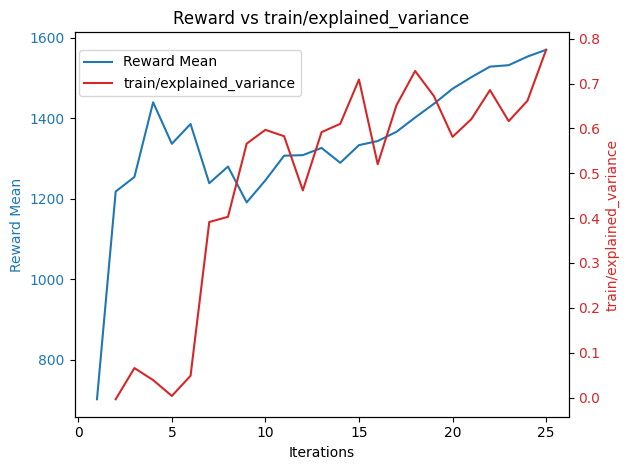

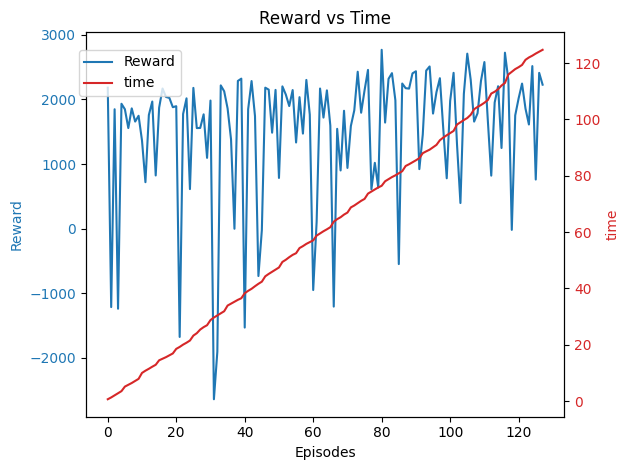

In [12]:
get_train_graph(logs_path, save=save_imgs)

## Comprobación funcionamiento


== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

DENY: 32.50%
ALLOW: 67.50%
Seed: 289980628190634006122751570777790489191
La ocupación máxima es de 90%
La ocupación mínima es de 0%


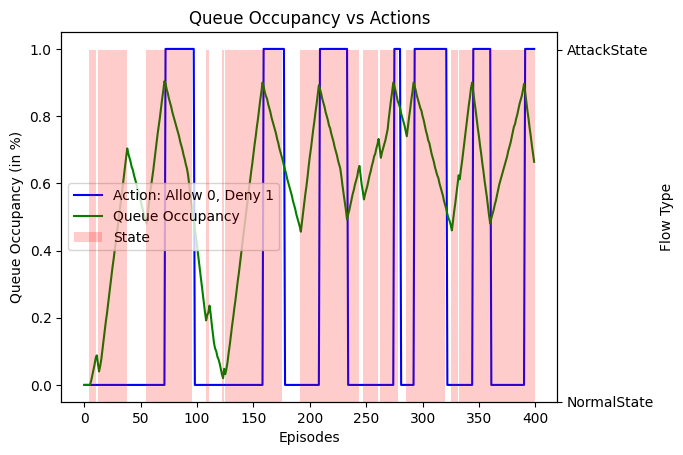

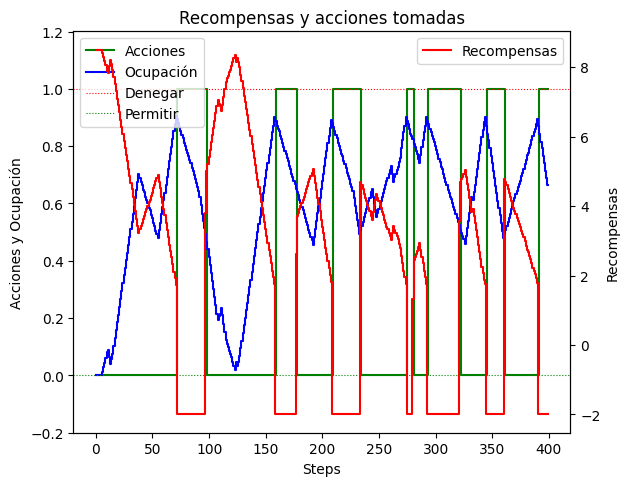

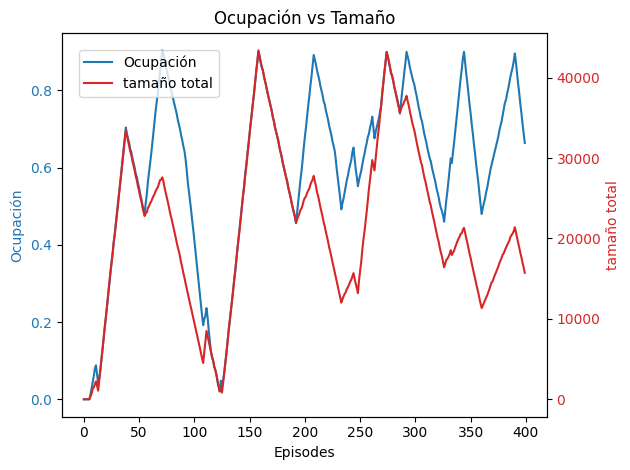

In [13]:
get_graphs(name,logs_path, save=save_imgs)